In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import clustering_utils
import math
from itertools import combinations
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster import cluster_visualizer

In [2]:
users_df = pd.read_csv("dataset/users_df_dataset_cleaned_with_indicators.csv")
users_df.dropna(inplace=True)
users_df.info(verbose=True)
users_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11108 entries, 0 to 11108
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   user_id                            11108 non-null  int64  
 1   name                               11108 non-null  object 
 2   lang                               11108 non-null  object 
 3   bot                                11108 non-null  int64  
 4   created_at                         11108 non-null  object 
 5   statuses_count                     11108 non-null  int64  
 6   account_age_in_days                11108 non-null  int64  
 7   number_of_tweets                   11108 non-null  int64  
 8   account_average_tweets_per_day     11108 non-null  float64
 9   avg_tweets_per_actual_day          11108 non-null  float64
 10  day_with_most_tweets               11108 non-null  object 
 11  max_number_of_tweet_in_a_day       11108 non-null  int

,user_id,bot,statuses_count,account_age_in_days,number_of_tweets,account_average_tweets_per_day,avg_tweets_per_actual_day,max_number_of_tweet_in_a_day,entropy_for_day,entropy_for_hour,...,avg_mentions,avg_special_char_in_text,total_likes,avt_favorite_count,total_replies,avt_reply_count,total_retweet_count,account_discussion_creation_ratio,tweet_num_likes_ratio,tweet_num_replies_ratio
count,1.110800e+04,11108.000000,11108.000000,11108.000000,11108.000000,11108.000000,11108.000000,11108.000000,11108.000000,11108.000000,...,11108.000000,11108.000000,1.110800e+04,11108.000000,1.110800e+04,11108.000000,1.110800e+04,11108.000000,11108.000000,11108.000000
mean,1.263557e+09,0.550594,485.581023,1827.635938,941.462099,0.262567,13.375639,52.167267,2.795125,1.995851,...,0.366510,15.984477,3.207350e+03,17.720968,9.357382e+02,0.603114,5.260731e+05,19.516091,17.395742,4.134271
std,9.362939e+08,0.497456,1239.154853,555.101424,1199.280505,0.679668,37.978610,87.945867,1.459904,1.086834,...,0.372442,5.572749,9.749861e+04,335.763909,2.983883e+04,12.406349,2.930989e+06,80.966312,46.418556,29.054618
min,6.780330e+05,0.000000,0.000000,891.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,4.662897e+08,0.000000,41.000000,1312.000000,67.000000,0.022468,1.844843,6.000000,1.426160,1.032655,...,0.010862,13.640096,3.000000e+00,0.023830,0.000000e+00,0.000000,3.000000e+00,0.001647,0.957845,0.000000
50%,1.127886e+09,1.000000,68.000000,1702.000000,132.000000,0.035088,4.777778,18.000000,2.921068,2.234410,...,0.318584,15.175357,1.000000e+01,0.064815,0.000000e+00,0.000000,7.650000e+01,0.040932,7.500000,0.000000
75%,2.356965e+09,1.000000,81.000000,2080.000000,1703.000000,0.058218,8.058232,75.000000,3.709885,2.788765,...,0.553218,17.798202,3.892500e+02,0.267803,0.000000e+00,0.000000,6.465900e+04,20.000000,20.800000,0.000000
max,3.164942e+09,1.000000,7226.000000,3901.000000,3668.000000,6.792821,1759.500000,2131.000000,5.706424,5.705947,...,5.701754,149.000000,7.006348e+06,13542.800000,2.000000e+06,603.318250,9.638758e+07,3519.000000,2877.000000,1762.000000


# X-means

X-means wants to resolve three major issues of K-means: K-means scales poorly computationally, the need of supplying the number of clusters K and the fact that the algorithm is prone to local minima.

In [3]:
indicator_columns_users = ['account_average_tweets_per_day', 'avg_tweets_per_actual_day', 'avg_hashtags', 
                            'avg_text_length', 'avg_mentions', 'avg_special_char_in_text', 'avt_favorite_count', 'total_replies',
                            'avt_reply_count', 'total_retweet_count', 'account_discussion_creation_ratio', 'tweet_num_likes_ratio',
                            'tweet_num_replies_ratio']

all_possible_combinations = list(combinations(indicator_columns_users, 2))
combination = ("avt_favorite_count", 'total_replies')
#combination = indicator_columns_users

In [4]:
subset_df = users_df[list(combination)]
scaler = StandardScaler()
scaler.fit(subset_df.values)
transform_result = scaler.fit_transform(subset_df.values)

In [29]:
initial_centers = kmeans_plusplus_initializer(transform_result, 2).initialize()
xmeans_instance = xmeans(transform_result, initial_centers, 40)
xmeans_instance.process()

In [30]:
clusters = xmeans_instance.get_clusters()

## Studying the composition of our clusters 

### Number of real bots and users in the cluster

In [31]:
is_bot = lambda index: users_df.iloc[index].bot == 1
clusters_ids = []
number_users_per_cluster = []
number_bots_per_cluster = []
for (cluster_index, indexes_in_cluster) in enumerate(clusters):
    number_real_users = 0
    number_bots = 0
    for user_index in indexes_in_cluster:
        if is_bot(user_index):
            number_bots += 1
        else:
            number_real_users += 1
    clusters_ids.append(cluster_index)
    number_users_per_cluster.append(number_real_users)
    number_bots_per_cluster.append(number_bots)

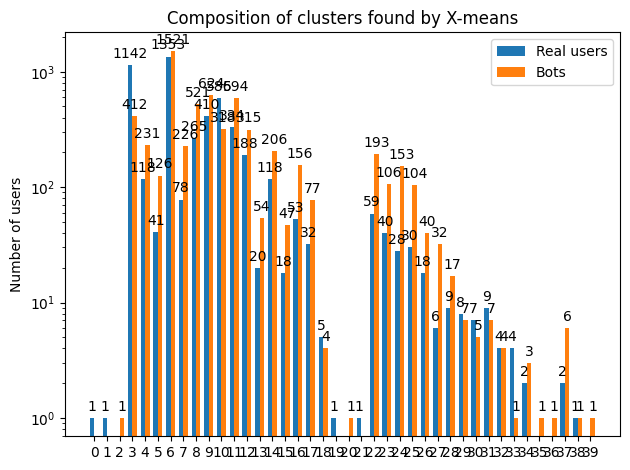

In [32]:
def plot_clusters_compositions(clusters_ids, number_users_per_cluster, number_bots_per_cluster):
    x = np.arange(len(clusters_ids))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, number_users_per_cluster, width, label='Real users', log=True)
    rects2 = ax.bar(x + width/2, number_bots_per_cluster, width, label='Bots', log=True)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Number of users')
    ax.set_title('Composition of clusters found by X-means')
    ax.set_xticks(x, clusters_ids)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.show()
   
plot_clusters_compositions(clusters_ids,number_users_per_cluster, number_bots_per_cluster)

### Entropy for the clusters

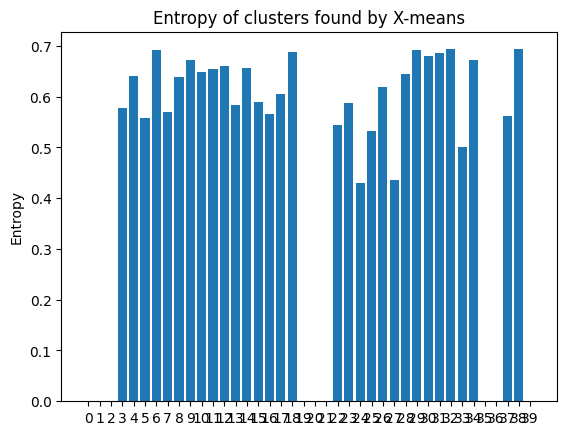

In [33]:
def visualize_clusters_entropy(clusters_ids: list, clusters_entropy: list):
    """
    Plots the entropy of the clusters
    
    :param clusters_ids: list of int, the ids of the clusters to study
    :param clusters_entropy: list of float, the value of entropy for each cluster; i.e. the i-th element of this list
        contains the entropy of the i-th cluster
    """
    x = np.arange(len(clusters_ids))
    
    fig, ax = plt.subplots()
    plt.bar(x=x, height=clusters_entropy)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Entropy')
    ax.set_title('Entropy of clusters found by X-means')
    ax.set_xticks(x, clusters_ids)
    
    plt.show()


compute_entropy = lambda p: -(p*math.log(p) + (1-p)*math.log(1-p)) if p != 1 and p != 0 else 0

clusters_entropy = []
for cluster_id in clusters_ids:
    number_users_in_cluster = number_users_per_cluster[cluster_id]
    number_bots_in_cluster = number_bots_per_cluster[cluster_id]
    total_number_of_elements = number_users_in_cluster + number_bots_in_cluster
    frequency_users = number_users_in_cluster / total_number_of_elements
    entropy = compute_entropy(frequency_users)
    clusters_entropy.append(entropy)
    
visualize_clusters_entropy(clusters_ids, clusters_entropy)

### Computing silhouette score for each cluster

In [24]:
def get_element_cluster(element, clusters):
    for (index, list_of_elements) in enumerate(clusters):
        if element in list_of_elements:
            return index

labels = [
    get_element_cluster(index, clusters)
    for index in range(len(users_df))
]
 
print(silhouette_score(transform_result, labels))

0.5308702150550868


# Other stuff not fully developed

In [11]:
def get_element_cluster(element, clusters):
    for (index, list_of_elements) in enumerate(clusters):
        if element in list_of_elements:
            return index

labels = [
    get_element_cluster(index, clusters)
    for index in range(len(users_df))
]

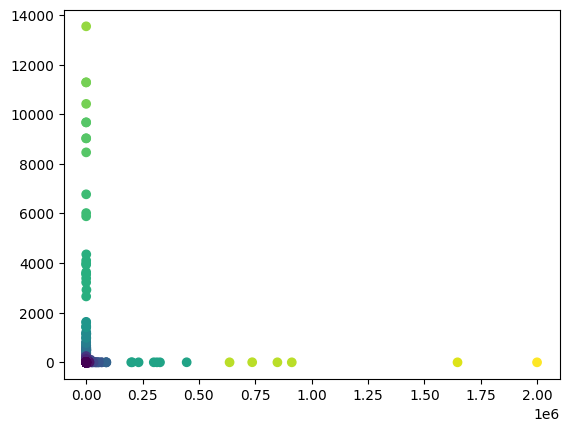

In [12]:
plt.scatter(data=users_df, x=combination[1], y=combination[0],c=labels)

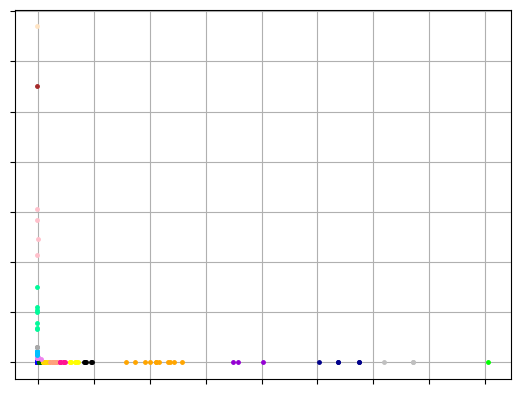

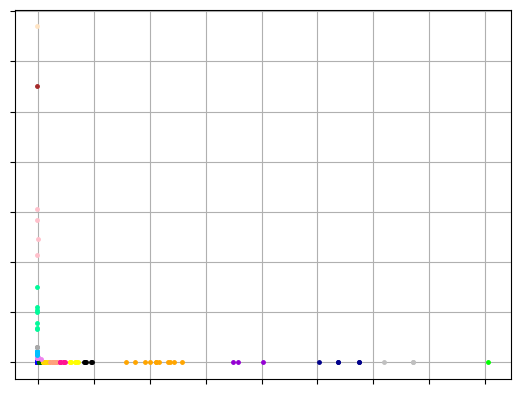

In [13]:
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, transform_result)
visualizer.show()

In [14]:
print("Total WCE:", xmeans_instance.get_total_wce())

Total WCE: 146.70288719228216


In [15]:
%%time
sse = []
for combination in all_possible_combinations:
    subset_df = users_df[list(combination)]
    scaler = StandardScaler()
    scaler.fit(subset_df.values)
    transform_result = scaler.fit_transform(subset_df.values)
    initial_centers = kmeans_plusplus_initializer(transform_result, 2).initialize()
    xmeans_instance = xmeans(transform_result, initial_centers, 20)
    xmeans_instance.process()
    sse.append((combination, xmeans_instance.get_total_wce()))

CPU times: user 30.9 s, sys: 2.66 s, total: 33.6 s
Wall time: 37.1 s


In [16]:
sse.sort(key=lambda x: x[1])

In [18]:
sse[0:5]

[(('avt_favorite_count', 'total_replies'), 146.76153119963692),
 (('avt_favorite_count', 'avt_reply_count'), 148.81106680212034),
 (('total_replies', 'tweet_num_replies_ratio'), 173.10241251671943),
 (('account_average_tweets_per_day', 'total_replies'), 195.89487203853818),
 (('total_replies', 'avt_reply_count'), 208.7670575860945)]